## FACENET + SVM APPROACH
## Part 1: Data Preparation & Embedding Extraction

In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import cv2
from tqdm import tqdm
import json
import pickle
import warnings
warnings.filterwarnings('ignore')

from mtcnn import MTCNN
from keras_facenet import FaceNet

print("="*60)
print("FACENET + SVM FACE RECOGNITION")
print("="*60)

FACENET + SVM FACE RECOGNITION


### CONFIGURATION

In [25]:
# Path Configuration
TRAIN_DIR = r"C:\Alip\Machine Learning\Train\Train"
PROCESSED_DIR = r"C:\Alip\Machine Learning\faces_processed"
OUTPUT_DIR = r"C:\Alip\Machine Learning\output_svm"

# Create output directories
os.makedirs(PROCESSED_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Model Configuration
IMG_SIZE = 160  # FaceNet uses 160x160
N_FOLDS = 2

print("\n✅ Configuration set!")
print(f"Output directory: {OUTPUT_DIR}")


✅ Configuration set!
Output directory: C:\Alip\Machine Learning\output_svm


### INITIALIZE MODELS

In [26]:
print("INITIALIZING MODELS")

print("Loading MTCNN face detector...")
detector = MTCNN()
print("✅ MTCNN initialized!")

print("Loading FaceNet model...")
facenet_model = FaceNet()
print("✅ FaceNet initialized!")
print(f"   Embedding dimension: 512")

INITIALIZING MODELS
Loading MTCNN face detector...
✅ MTCNN initialized!
Loading FaceNet model...
✅ FaceNet initialized!
   Embedding dimension: 512


### FACE DETECTION & PREPROCESSING

In [27]:
def detect_and_crop_face(image_path, target_size=(160, 160)):
    """Detect face in image and crop it"""
    try:
        img = cv2.imread(image_path)
        if img is None:
            return None
        
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        results = detector.detect_faces(img_rgb)
        
        if len(results) == 0:
            print(f"⚠️  No face detected in {os.path.basename(image_path)}, using full image")
            return cv2.resize(img_rgb, target_size)
        
        # Get largest face
        largest_face = max(results, key=lambda x: x['box'][2] * x['box'][3])
        x, y, w, h = largest_face['box']
        
        # Add margin (20%)
        margin = int(0.2 * max(w, h))
        x1 = max(0, x - margin)
        y1 = max(0, y - margin)
        x2 = min(img_rgb.shape[1], x + w + margin)
        y2 = min(img_rgb.shape[0], y + h + margin)
        
        face = img_rgb[y1:y2, x1:x2]
        face_resized = cv2.resize(face, target_size)
        
        return face_resized
    except Exception as e:
        print(f"❌ Error processing {image_path}: {str(e)}")
        return None


### PREPROCESS DATASET

In [28]:
print("PREPROCESSING: Detecting and Cropping Faces")

# Check if already preprocessed
if len(os.listdir(PROCESSED_DIR)) > 0:
    print("⚠️  Processed directory not empty.")
    user_input = input("Reprocess? (y/n): ")
    if user_input.lower() == 'y':
        import shutil
        shutil.rmtree(PROCESSED_DIR)
        os.makedirs(PROCESSED_DIR)
    else:
        print("✅ Using existing processed data")

if len(os.listdir(PROCESSED_DIR)) == 0:
    total_images = 0
    successful_images = 0
    
    for class_name in tqdm(os.listdir(TRAIN_DIR), desc="Processing classes"):
        class_path = os.path.join(TRAIN_DIR, class_name)
        if not os.path.isdir(class_path):
            continue
        
        output_class_dir = os.path.join(PROCESSED_DIR, class_name)
        os.makedirs(output_class_dir, exist_ok=True)
        
        images = [f for f in os.listdir(class_path) 
                  if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
        
        for img_name in images:
            total_images += 1
            img_path = os.path.join(class_path, img_name)
            face = detect_and_crop_face(img_path)
            
            if face is not None:
                output_path = os.path.join(output_class_dir, img_name)
                cv2.imwrite(output_path, cv2.cvtColor(face, cv2.COLOR_RGB2BGR))
                successful_images += 1
    
    print(f"\n✅ Preprocessing Complete!")
    print(f"   Successful: {successful_images}/{total_images}")


PREPROCESSING: Detecting and Cropping Faces
⚠️  Processed directory not empty.
✅ Using existing processed data


### LOAD DATASET

In [29]:
def load_dataset(data_dir):
    """Load all preprocessed images"""
    X, y, class_to_idx = [], [], {}
    
    for idx, class_name in enumerate(sorted(os.listdir(data_dir))):
        class_path = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        
        class_to_idx[class_name] = idx
        
        for img_name in os.listdir(class_path):
            if not img_name.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                continue
            
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                X.append(img)
                y.append(idx)
    
    return np.array(X), np.array(y), class_to_idx

print("\n" + "="*60)
print("LOADING DATASET")
print("="*60)

X, y, class_to_idx = load_dataset(PROCESSED_DIR)
idx_to_class = {v: k for k, v in class_to_idx.items()}
num_classes = len(class_to_idx)

print(f"Total samples: {len(X)}")
print(f"Number of classes: {num_classes}")
print(f"Image shape: {X.shape[1:]}")
print(f"Samples per class (avg): {len(X) / num_classes:.2f}")
print("="*60)



LOADING DATASET
Total samples: 284
Number of classes: 70
Image shape: ()
Samples per class (avg): 4.06


### CUSTOM SPLIT: 1 SAMPLE PER CLASS FOR TEST

In [30]:
def stratified_split_by_count(X, y, test_samples_per_class=1, random_state=42):
    """Split dataset: N samples per class for test"""
    np.random.seed(random_state)
    
    train_indices = []
    test_indices = []
    
    for class_id in np.unique(y):
        class_indices = np.where(y == class_id)[0]
        np.random.shuffle(class_indices)
        
        n_test = min(test_samples_per_class, len(class_indices))
        test_idx = class_indices[:n_test]
        train_idx = class_indices[n_test:]
        
        test_indices.extend(test_idx)
        train_indices.extend(train_idx)
    
    train_indices = np.array(train_indices)
    test_indices = np.array(test_indices)
    
    return X[train_indices], X[test_indices], y[train_indices], y[test_indices]

print("\n" + "="*60)
print("SPLITTING DATASET: 1 Sample per Class for Test")
print("="*60)

X_train, X_test, y_train, y_test = stratified_split_by_count(
    X, y, test_samples_per_class=1, random_state=42
)

print(f"Total samples: {len(X)}")
print(f"Train samples: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Test samples: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")
print(f"Train per class (avg): {len(X_train)/num_classes:.2f}")
print(f"Test per class: 1")

# Verify all classes in test set
unique_test_classes = len(np.unique(y_test))
print(f"\n✅ Verification: {unique_test_classes}/{num_classes} classes in test set")
if unique_test_classes == num_classes:
    print("   ✓ All classes represented!")


SPLITTING DATASET: 1 Sample per Class for Test
Total samples: 284
Train samples: 214 (75.4%)
Test samples: 70 (24.6%)
Train per class (avg): 3.06
Test per class: 1

✅ Verification: 70/70 classes in test set
   ✓ All classes represented!


### EXTRACT FACENET EMBEDDINGS

In [31]:
def extract_embeddings(images, model, batch_size=32):
    """Extract FaceNet embeddings from images"""
    embeddings = []
    
    for i in tqdm(range(0, len(images), batch_size), desc="Extracting embeddings"):
        batch = images[i:i+batch_size]
        batch_embeddings = model.embeddings(batch)
        embeddings.append(batch_embeddings)
    
    return np.vstack(embeddings)

print("\n" + "="*60)
print("EXTRACTING FACENET EMBEDDINGS")
print("="*60)
print("This will take a few minutes...")

# Extract embeddings for train set
print("\n📊 Processing training set...")
X_train_embeddings = extract_embeddings(X_train, facenet_model, batch_size=32)

# Extract embeddings for test set
print("\n📊 Processing test set...")
X_test_embeddings = extract_embeddings(X_test, facenet_model, batch_size=32)

print(f"\n✅ Embedding extraction complete!")
print(f"   Train embeddings shape: {X_train_embeddings.shape}")
print(f"   Test embeddings shape: {X_test_embeddings.shape}")
print(f"   Embedding dimension: {X_train_embeddings.shape[1]}")

# Save embeddings
embeddings_path = os.path.join(OUTPUT_DIR, 'embeddings.npz')
np.savez(embeddings_path, 
         X_train=X_train_embeddings, 
         X_test=X_test_embeddings,
         y_train=y_train,
         y_test=y_test)
print(f"💾 Embeddings saved to: {embeddings_path}")

# Save metadata
metadata = {
    'num_classes': num_classes,
    'total_samples': len(X),
    'train_samples': len(X_train),
    'test_samples': len(X_test),
    'embedding_dim': X_train_embeddings.shape[1],
    'class_to_idx': class_to_idx,
    'idx_to_class': idx_to_class
}

metadata_path = os.path.join(OUTPUT_DIR, 'metadata.json')
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"💾 Metadata saved to: {metadata_path}")

print("\n" + "="*60)
print("PART 1 COMPLETE!")
print("="*60)
print("✅ Face detection and preprocessing done")
print("✅ Dataset split (1 sample/class for test)")
print("✅ FaceNet embeddings extracted")
print("\nNext: Run Part 2 to train classifiers and evaluate!")
print("="*60)


EXTRACTING FACENET EMBEDDINGS
This will take a few minutes...

📊 Processing training set...


Extracting embeddings:   0%|          | 0/7 [00:00<?, ?it/s]

1/1 [==============================] - 4s 4s/step


Extracting embeddings:  14%|█▍        | 1/7 [00:03<00:23,  3.83s/it]

1/1 [==============================] - 1s 1s/step


Extracting embeddings:  29%|██▊       | 2/7 [00:04<00:11,  2.25s/it]

1/1 [==============================] - 1s 1s/step


Extracting embeddings:  43%|████▎     | 3/7 [00:06<00:07,  1.96s/it]

1/1 [==============================] - 1s 1s/step


Extracting embeddings:  57%|█████▋    | 4/7 [00:07<00:04,  1.66s/it]

1/1 [==============================] - 1s 1s/step


Extracting embeddings:  71%|███████▏  | 5/7 [00:09<00:03,  1.61s/it]

1/1 [==============================] - 1s 1s/step


Extracting embeddings:  86%|████████▌ | 6/7 [00:10<00:01,  1.57s/it]

1/1 [==============================] - 3s 3s/step


Extracting embeddings: 100%|██████████| 7/7 [00:14<00:00,  2.05s/it]



📊 Processing test set...


Extracting embeddings:   0%|          | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step


Extracting embeddings:  33%|███▎      | 1/3 [00:01<00:02,  1.12s/it]

1/1 [==============================] - 1s 1s/step


Extracting embeddings:  67%|██████▋   | 2/3 [00:02<00:01,  1.31s/it]

1/1 [==============================] - 0s 262ms/step


Extracting embeddings: 100%|██████████| 3/3 [00:02<00:00,  1.02it/s]


✅ Embedding extraction complete!
   Train embeddings shape: (214, 512)
   Test embeddings shape: (70, 512)
   Embedding dimension: 512
💾 Embeddings saved to: C:\Alip\Machine Learning\output_svm\embeddings.npz
💾 Metadata saved to: C:\Alip\Machine Learning\output_svm\metadata.json

PART 1 COMPLETE!
✅ Face detection and preprocessing done
✅ Dataset split (1 sample/class for test)
✅ FaceNet embeddings extracted

Next: Run Part 2 to train classifiers and evaluate!


## FACENET + SVM APPROACH
## Part 2: Classifier Training & Evaluation

In [32]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import json
import pickle
import warnings
warnings.filterwarnings('ignore')

print("="*60)
print("PART 2: CLASSIFIER TRAINING & EVALUATION")
print("="*60)

PART 2: CLASSIFIER TRAINING & EVALUATION


## LOAD EMBEDDINGS & METADATA

In [33]:
OUTPUT_DIR = r"C:\Alip\Machine Learning\output_svm"

print("\nLoading embeddings and metadata...")
embeddings_data = np.load(os.path.join(OUTPUT_DIR, 'embeddings.npz'))
X_train_embeddings = embeddings_data['X_train']
X_test_embeddings = embeddings_data['X_test']
y_train = embeddings_data['y_train']
y_test = embeddings_data['y_test']

with open(os.path.join(OUTPUT_DIR, 'metadata.json'), 'r') as f:
    metadata = json.load(f)

num_classes = metadata['num_classes']
idx_to_class = {int(k): v for k, v in metadata['idx_to_class'].items()}
class_to_idx = metadata['class_to_idx']

print(f"✅ Data loaded!")
print(f"   Train embeddings: {X_train_embeddings.shape}")
print(f"   Test embeddings: {X_test_embeddings.shape}")
print(f"   Number of classes: {num_classes}")


Loading embeddings and metadata...
✅ Data loaded!
   Train embeddings: (214, 512)
   Test embeddings: (70, 512)
   Number of classes: 70


## TRAIN MULTIPLE CLASSIFIERS

In [34]:
print("TRAINING CLASSIFIERS")

# Define classifiers to test
classifiers = {
    'SVM (Linear)': SVC(kernel='linear', C=1.0, probability=True),
    'SVM (RBF)': SVC(kernel='rbf', C=1.0, gamma='scale', probability=True),
    'KNN (k=3)': KNeighborsClassifier(n_neighbors=3, metric='euclidean'),
    'KNN (k=5)': KNeighborsClassifier(n_neighbors=5, metric='euclidean'),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42)
}

results = {}
trained_models = {}

for clf_name, clf in classifiers.items():
    print(f"\n{'='*60}")
    print(f"Training: {clf_name}")
    print(f"{'='*60}")
    
    # Train on full training set
    clf.fit(X_train_embeddings, y_train)
    
    # Evaluate on test set
    y_pred = clf.predict(X_test_embeddings)
    test_acc = accuracy_score(y_test, y_pred)
    
    print(f"✅ Test Accuracy: {test_acc*100:.2f}%")
    
    # Store results
    results[clf_name] = {
        'test_accuracy': test_acc,
        'predictions': y_pred
    }
    trained_models[clf_name] = clf

TRAINING CLASSIFIERS

Training: SVM (Linear)
✅ Test Accuracy: 95.71%

Training: SVM (RBF)
✅ Test Accuracy: 95.71%

Training: KNN (k=3)
✅ Test Accuracy: 95.71%

Training: KNN (k=5)
✅ Test Accuracy: 90.00%

Training: Logistic Regression
✅ Test Accuracy: 87.14%


### SELECT BEST MODEL

In [35]:
print("MODEL COMPARISON")

print(f"\n{'Classifier':<25} {'Test Accuracy':<15}")
print("-"*60)
for name, res in results.items():
    print(f"{name:<25} {res['test_accuracy']*100:>13.2f}%")
print("="*60)

# Find best classifier
best_clf_name = max(results, key=lambda x: results[x]['test_accuracy'])
best_model = trained_models[best_clf_name]
best_acc = results[best_clf_name]['test_accuracy']
y_pred_best = results[best_clf_name]['predictions']

print(f"\n🏆 BEST CLASSIFIER: {best_clf_name}")
print(f"   Test Accuracy: {best_acc*100:.2f}%")

# Save best model
model_path = os.path.join(OUTPUT_DIR, 'best_classifier.pkl')
with open(model_path, 'wb') as f:
    pickle.dump(best_model, f)
print(f"\n💾 Best model saved to: {model_path}")

MODEL COMPARISON

Classifier                Test Accuracy  
------------------------------------------------------------
SVM (Linear)                      95.71%
SVM (RBF)                         95.71%
KNN (k=3)                         95.71%
KNN (k=5)                         90.00%
Logistic Regression               87.14%

🏆 BEST CLASSIFIER: SVM (Linear)
   Test Accuracy: 95.71%

💾 Best model saved to: C:\Alip\Machine Learning\output_svm\best_classifier.pkl


## DETAILED EVALUATION (BEST MODEL)

In [36]:
print("\n" + "="*60)
print("DETAILED EVALUATION - BEST MODEL")
print("="*60)

# Classification Report
class_labels = [idx_to_class[i] for i in range(num_classes)]
print(f"\nClassifier: {best_clf_name}")
print(f"Test Accuracy: {best_acc*100:.2f}%")
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
report = classification_report(y_test, y_pred_best, target_names=class_labels, zero_division=0)
print(report)

# Save report
report_path = os.path.join(OUTPUT_DIR, 'classification_report.txt')
with open(report_path, 'w') as f:
    f.write(f"Best Classifier: {best_clf_name}\n")
    f.write(f"Test Accuracy: {best_acc*100:.2f}%\n\n")
    f.write(report)
print(f"💾 Report saved to: {report_path}")


DETAILED EVALUATION - BEST MODEL

Classifier: SVM (Linear)
Test Accuracy: 95.71%

CLASSIFICATION REPORT
                                 precision    recall  f1-score   support

           Abraham Ganda Napitu       1.00      1.00      1.00         1
       Abu Bakar Siddiq Siregar       1.00      1.00      1.00         1
             Ahmad Faqih Hasani       1.00      1.00      1.00         1
                   Aldi Sanjaya       1.00      1.00      1.00         1
                        Alfajar       1.00      1.00      1.00         1
            Alief Fathur Rahman       1.00      1.00      1.00         1
 Arkan Hariz Chandrawinata Liem       1.00      1.00      1.00         1
               Bayu Ega Ferdana       1.00      1.00      1.00         1
          Bayu Prameswara Haris       1.00      1.00      1.00         1
           Bezalel Samuel Manik       1.00      1.00      1.00         1
           Bintang Fikri Fauzan       0.00      0.00      0.00         1
              Boy 

## CONFUSION MATRIX



GENERATING CONFUSION MATRIX


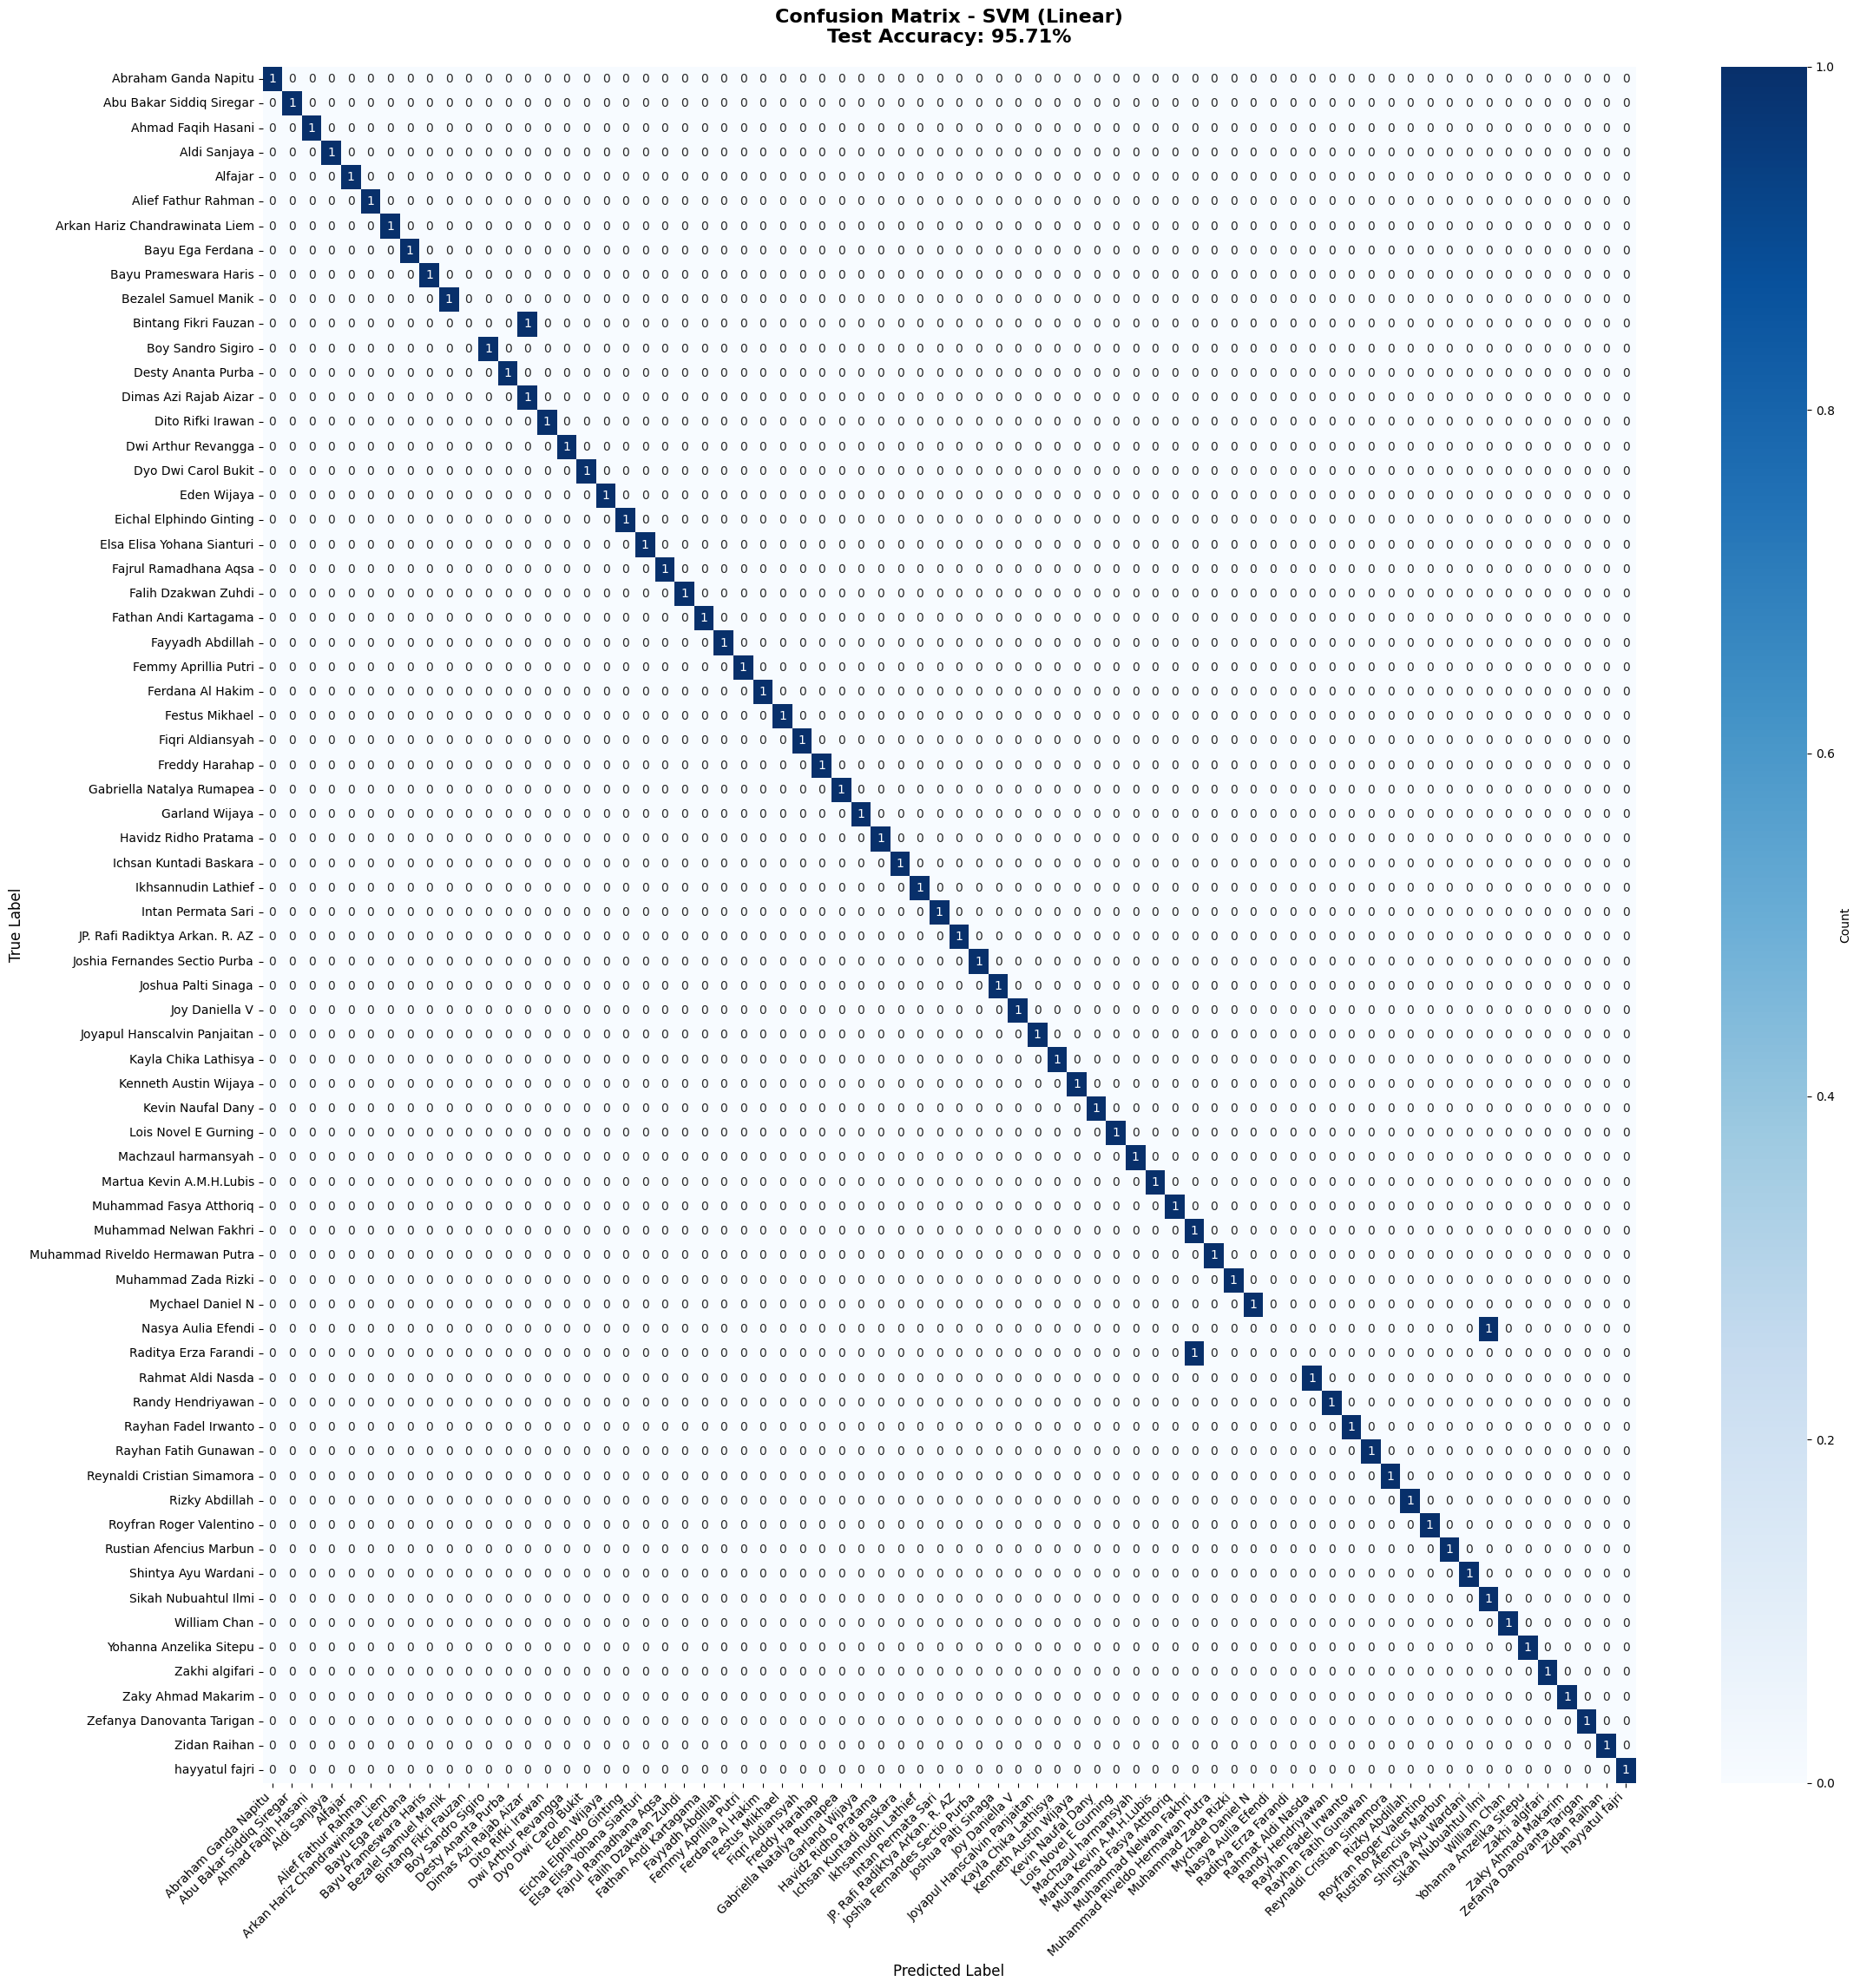

💾 Confusion matrix saved to: C:\Alip\Machine Learning\output_svm\confusion_matrix.png


In [37]:
print("\n" + "="*60)
print("GENERATING CONFUSION MATRIX")
print("="*60)

cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(max(15, num_classes//3), max(12, num_classes//3)))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels,
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix - {best_clf_name}\nTest Accuracy: {best_acc*100:.2f}%', 
          fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

cm_path = os.path.join(OUTPUT_DIR, 'confusion_matrix.png')
plt.savefig(cm_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"💾 Confusion matrix saved to: {cm_path}")

## CLASSIFIER COMPARISON PLOT

CREATING COMPARISON PLOTS


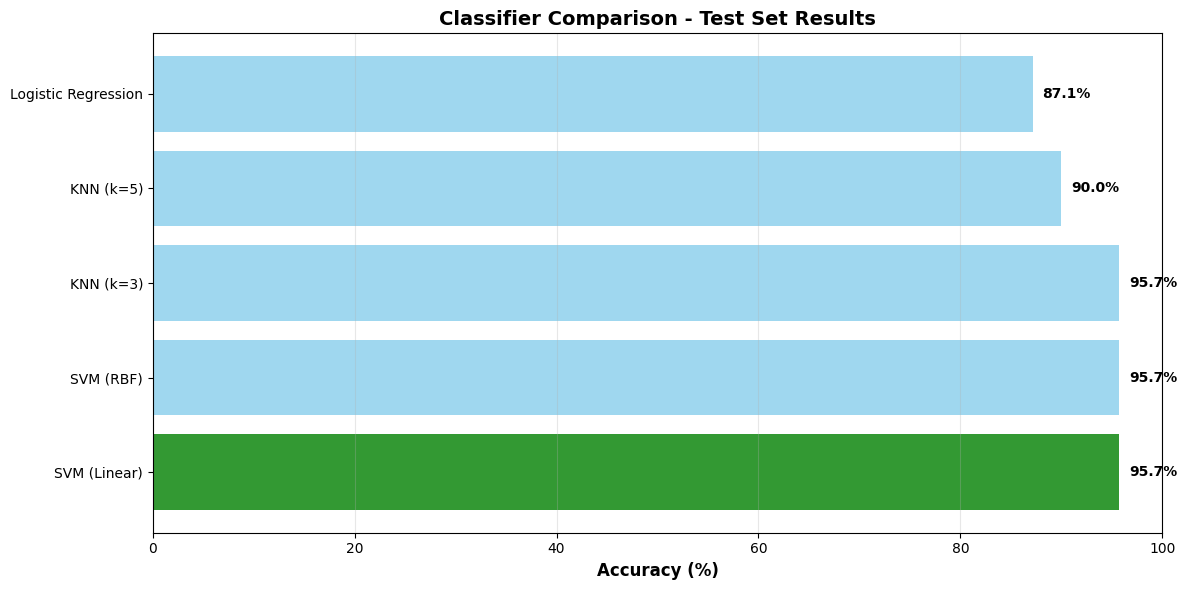

💾 Comparison plot saved to: C:\Alip\Machine Learning\output_svm\classifier_comparison.png


In [38]:
print("CREATING COMPARISON PLOTS")

fig, ax = plt.subplots(figsize=(12, 6))

clf_names = list(results.keys())
test_accs = [results[name]['test_accuracy']*100 for name in clf_names]

colors = ['green' if name == best_clf_name else 'skyblue' for name in clf_names]
bars = ax.barh(clf_names, test_accs, color=colors, alpha=0.8)

ax.set_xlabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax.set_title('Classifier Comparison - Test Set Results', fontsize=14, fontweight='bold')
ax.set_xlim(0, 100)
ax.grid(axis='x', alpha=0.3)

# Add value labels
for i, (name, acc) in enumerate(zip(clf_names, test_accs)):
    ax.text(acc + 1, i, f'{acc:.1f}%', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
comparison_path = os.path.join(OUTPUT_DIR, 'classifier_comparison.png')
plt.savefig(comparison_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"💾 Comparison plot saved to: {comparison_path}")

## PER-CLASSIFIER CONFUSION MATRICES

GENERATING ALL CONFUSION MATRICES


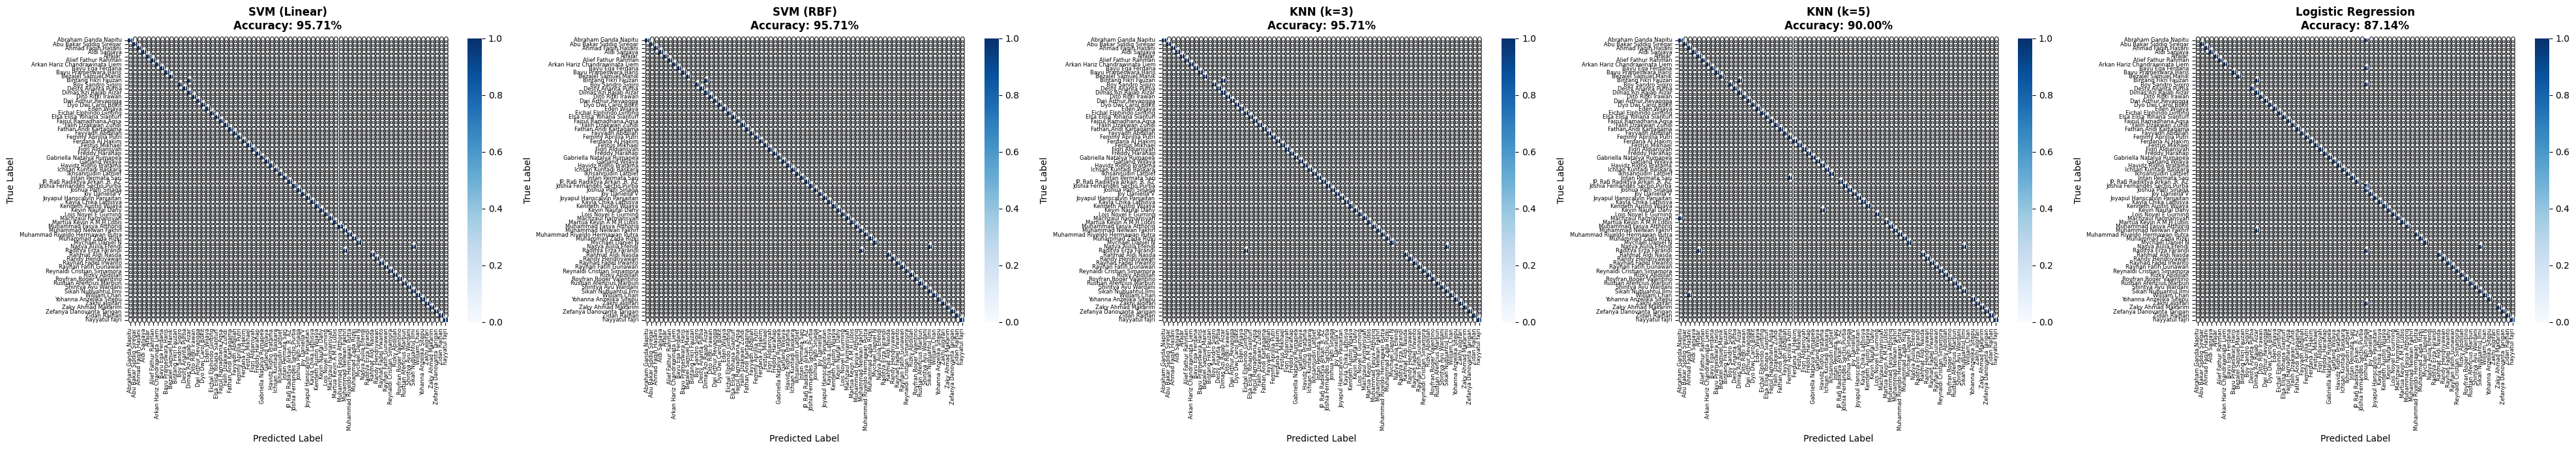

💾 All confusion matrices saved to: C:\Alip\Machine Learning\output_svm\all_confusion_matrices.png


In [39]:
print("GENERATING ALL CONFUSION MATRICES")

n_classifiers = len(classifiers)
fig, axes = plt.subplots(1, n_classifiers, figsize=(8*n_classifiers, 7))

if n_classifiers == 1:
    axes = [axes]

for idx, (name, res) in enumerate(results.items()):
    cm = confusion_matrix(y_test, res['predictions'])
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels,
                ax=axes[idx], cbar=True, square=False)
    
    acc = res['test_accuracy'] * 100
    axes[idx].set_title(f'{name}\nAccuracy: {acc:.2f}%', 
                       fontsize=12, fontweight='bold', pad=10)
    axes[idx].set_ylabel('True Label', fontsize=10)
    axes[idx].set_xlabel('Predicted Label', fontsize=10)
    axes[idx].tick_params(axis='both', labelsize=6)

plt.tight_layout()
all_cm_path = os.path.join(OUTPUT_DIR, 'all_confusion_matrices.png')
plt.savefig(all_cm_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"💾 All confusion matrices saved to: {all_cm_path}")

## PREDICTION FUNCTION

In [40]:
def predict_face(image_path, facenet_model, classifier, idx_to_class, 
                 detector, threshold=0.5):

    from mtcnn import MTCNN
    import cv2
    
    # Detect face
    img = cv2.imread(image_path)
    if img is None:
        print("❌ Cannot read image!")
        return None, 0
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = detector.detect_faces(img_rgb)
    
    if len(results) == 0:
        print("❌ No face detected!")
        return None, 0
    
    # Crop largest face
    largest_face = max(results, key=lambda x: x['box'][2] * x['box'][3])
    x, y, w, h = largest_face['box']
    margin = int(0.2 * max(w, h))
    x1 = max(0, x - margin)
    y1 = max(0, y - margin)
    x2 = min(img_rgb.shape[1], x + w + margin)
    y2 = min(img_rgb.shape[0], y + h + margin)
    
    face = img_rgb[y1:y2, x1:x2]
    face_resized = cv2.resize(face, (160, 160))
    
    # Extract embedding
    embedding = facenet_model.embeddings([face_resized])[0].reshape(1, -1)
    
    # Predict
    prediction = classifier.predict(embedding)[0]
    
    # Get confidence/probability
    if hasattr(classifier, 'predict_proba'):
        proba = classifier.predict_proba(embedding)[0]
        confidence = proba[prediction]
        top_5_idx = np.argsort(proba)[-5:][::-1]
        top_5_names = [idx_to_class[i] for i in top_5_idx]
        top_5_probs = proba[top_5_idx]
    elif hasattr(classifier, 'kneighbors'):
        distances, _ = classifier.kneighbors(embedding)
        confidence = 1.0 / (1.0 + np.mean(distances))
        proba = classifier.predict_proba(embedding)[0]
        top_5_idx = np.argsort(proba)[-5:][::-1]
        top_5_names = [idx_to_class[i] for i in top_5_idx]
        top_5_probs = proba[top_5_idx]
    else:
        confidence = 1.0
        top_5_names = [idx_to_class[prediction]]
        top_5_probs = [1.0]
    
    predicted_name = idx_to_class[prediction]
    is_unknown = confidence < threshold
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Show face
    axes[0].imshow(face_resized)
    if is_unknown:
        axes[0].set_title(f"⚠️ UNKNOWN PERSON\n(Confidence: {confidence:.2%})", 
                         fontsize=14, fontweight='bold', color='red')
    else:
        axes[0].set_title(f"Predicted: {predicted_name}\n(Confidence: {confidence:.2%})", 
                         fontsize=14, fontweight='bold', color='green')
    axes[0].axis('off')
    
    # Show top 5 predictions
    colors = ['green' if i == 0 and not is_unknown else 'lightcoral' if is_unknown else 'lightblue' 
              for i in range(len(top_5_names))]
    axes[1].barh(top_5_names, top_5_probs, color=colors)
    axes[1].set_xlabel('Confidence', fontsize=12)
    axes[1].set_title('Top 5 Predictions', fontsize=14, fontweight='bold')
    axes[1].invert_yaxis()
    axes[1].set_xlim(0, 1)
    axes[1].axvline(x=threshold, color='red', linestyle='--', label='Threshold')
    axes[1].legend()
    
    for i, (name, prob) in enumerate(zip(top_5_names, top_5_probs)):
        axes[1].text(prob + 0.02, i, f'{prob:.2%}', va='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    if is_unknown:
        print(f"\n⚠️  UNKNOWN PERSON")
        print(f"   Confidence too low: {confidence:.2%} < {threshold:.2%}")
        return "UNKNOWN", confidence
    else:
        print(f"\n✅ Prediction: {predicted_name}")
        print(f"   Confidence: {confidence:.2%}")
        return predicted_name, confidence

print("\n✅ Prediction function ready!")
print("\n📌 Usage:")
print("from keras_facenet import FaceNet")
print("from mtcnn import MTCNN")
print("facenet_model = FaceNet()")
print("detector = MTCNN()")
print("predict_face('path/to/image.jpg', facenet_model, best_model, idx_to_class, detector)")


✅ Prediction function ready!

📌 Usage:
from keras_facenet import FaceNet
from mtcnn import MTCNN
facenet_model = FaceNet()
detector = MTCNN()
predict_face('path/to/image.jpg', facenet_model, best_model, idx_to_class, detector)


## SAVE RESULTS SUMMARY

In [41]:
results_summary = {
    'best_classifier': best_clf_name,
    'test_accuracy': float(best_acc),
    'all_classifiers': {
        name: {
            'test_accuracy': float(results[name]['test_accuracy'])
        }
        for name in clf_names
    },
    'dataset_info': metadata
}

results_path = os.path.join(OUTPUT_DIR, 'results_summary.json')
with open(results_path, 'w') as f:
    json.dump(results_summary, f, indent=2)

## FINAL SUMMARY

In [42]:
print("TRAINING COMPLETE - FINAL SUMMARY")
print("="*60)
print(f"Dataset: {metadata['total_samples']} images, {num_classes} classes")
print(f"Split: {metadata['train_samples']} train, {metadata['test_samples']} test")
print(f"\nClassifiers Trained: {len(classifiers)}")
for name, res in results.items():
    print(f"  • {name}: {res['test_accuracy']*100:.2f}%")
print(f"\n🏆 Best Classifier: {best_clf_name}")
print(f"   Test Accuracy: {best_acc*100:.2f}%")
print(f"\nOutput Directory: {OUTPUT_DIR}")
print("="*60)
print("\n🎉 Ready for inference!")
print("Use predict_face() function to test on new images.")
print("\nFiles saved:")
print("  ✓ best_classifier.pkl")
print("  ✓ embeddings.npz")
print("  ✓ metadata.json")
print("  ✓ classification_report.txt")
print("  ✓ confusion_matrix.png")
print("  ✓ classifier_comparison.png")
print("  ✓ all_confusion_matrices.png")
print("  ✓ results_summary.json")
print("="*60)

TRAINING COMPLETE - FINAL SUMMARY
Dataset: 284 images, 70 classes
Split: 214 train, 70 test

Classifiers Trained: 5
  • SVM (Linear): 95.71%
  • SVM (RBF): 95.71%
  • KNN (k=3): 95.71%
  • KNN (k=5): 90.00%
  • Logistic Regression: 87.14%

🏆 Best Classifier: SVM (Linear)
   Test Accuracy: 95.71%

Output Directory: C:\Alip\Machine Learning\output_svm

🎉 Ready for inference!
Use predict_face() function to test on new images.

Files saved:
  ✓ best_classifier.pkl
  ✓ embeddings.npz
  ✓ metadata.json
  ✓ classification_report.txt
  ✓ confusion_matrix.png
  ✓ classifier_comparison.png
  ✓ all_confusion_matrices.png
  ✓ results_summary.json


## Inference

1/1 [==============================] - 3s 3s/step


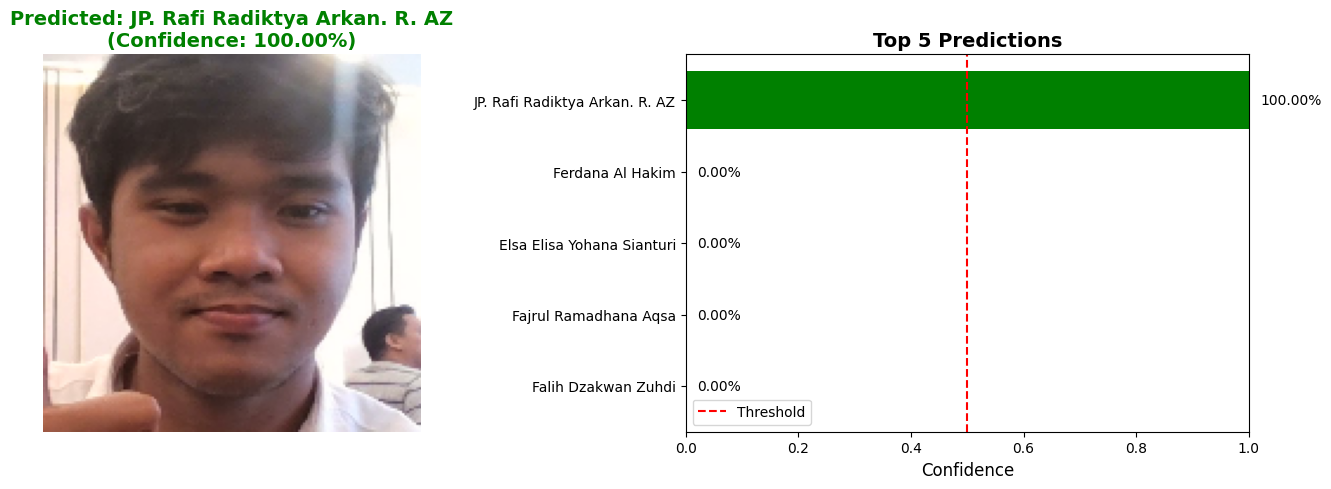


✅ Prediction: JP. Rafi Radiktya Arkan. R. AZ
   Confidence: 100.00%


('JP. Rafi Radiktya Arkan. R. AZ', 1.0)

In [43]:
# Load model & dependencies
from keras_facenet import FaceNet
from mtcnn import MTCNN
import pickle

facenet_model = FaceNet()
detector = MTCNN()

# Load classifier SVM
with open('output_svm/best_classifier.pkl', 'rb') as f:
    classifier = pickle.load(f)

# Path ke gambar barumu
image_path = r"C:/Alip/Machine Learning/Test/WhatsApp Image 2025-12-01 at 20.05.08_9d8dc293.jpg"

# Predict
predict_face(
    image_path, 
    facenet_model, 
    classifier, 
    idx_to_class, 
    detector,
    threshold=0.5  # threshold untuk deteksi unknown
)


## VGGFace + Softmax Classifier


In [82]:
import os
import numpy as np
import cv2
from tqdm import tqdm

DATASET_DIR = r"C:/Alip/Machine Learning/faces_processed"

IMG_SIZE = 224

X = []
y = []
class_names = []

# -------------------------------------------------------------------
# 1. Load folder → baca foto → resize → simpan
# -------------------------------------------------------------------
print("📥 Loading dataset from:", DATASET_DIR)

for label, person in enumerate(os.listdir(DATASET_DIR)):
    person_path = os.path.join(DATASET_DIR, person)
    if not os.path.isdir(person_path):
        continue

    class_names.append(person)

    for img_name in os.listdir(person_path):
        img_path = os.path.join(person_path, img_name)
        img = cv2.imread(img_path)

        if img is None:
            print("⚠️ Cannot read:", img_path)
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

        X.append(img)
        y.append(label)

X = np.array(X, dtype="float32")
y = np.array(y)

print("✔ Dataset loaded!")
print("Total images:", len(X))
print("Total classes:", len(class_names))


📥 Loading dataset from: C:/Alip/Machine Learning/faces_processed
✔ Dataset loaded!
Total images: 284
Total classes: 70


In [83]:
from sklearn.model_selection import train_test_split

# Stratified split automatic (test_size = 1 image per class)
test_size = len(np.unique(y)) / len(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=test_size,
    random_state=42,
    stratify=y
)

print("\nTrain:", X_train.shape)
print("Test :", X_test.shape)



Train: (214, 224, 224, 3)
Test : (70, 224, 224, 3)


In [84]:
from keras_vggface.utils import preprocess_input

X_train_vgg = preprocess_input(X_train.copy(), version=2)
X_test_vgg  = preprocess_input(X_test.copy(), version=2)

# One-hot
from tensorflow.keras.utils import to_categorical
num_classes = len(class_names)

y_train_cat = to_categorical(y_train, num_classes)
y_test_cat  = to_categorical(y_test,  num_classes)


In [85]:
import tensorflow as tf

BATCH_SIZE = 8
AUTOTUNE = tf.data.AUTOTUNE

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.10),
    tf.keras.layers.RandomZoom(0.10),
])

train_ds = (
    tf.data.Dataset.from_tensor_slices((X_train_vgg, y_train_cat))
    .shuffle(len(X_train_vgg))
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

val_ds = (
    tf.data.Dataset.from_tensor_slices((X_test_vgg, y_test_cat))
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)


In [86]:
from keras_vggface.vggface import VGGFace
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model

print("\n🔥 Building VGGFace ResNet50 model...")

base_model = VGGFace(
    model='resnet50',
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg'
)

base_model.trainable = False  # freeze backbone

inputs = Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model_vgg = Model(inputs, outputs)
model_vgg.summary()



🔥 Building VGGFace ResNet50 model...
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 vggface_resnet50 (Functiona  (None, 2048)             23561152  
 l)                                                              
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                     

In [87]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model_vgg.compile(
    optimizer=Adam(1e-3),  # wajib 1e-3 biar normal
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=8,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    patience=4,
    factor=0.5,
    min_lr=1e-6
)

history = model_vgg.fit(
    train_ds,
    epochs=40,
    validation_data=val_ds,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/40
27/27 [==============================] - 34s 1s/step - loss: 10.3645 - accuracy: 0.0561 - val_loss: 2.7203 - val_accuracy: 0.3714 - lr: 0.0010
Epoch 2/40
27/27 [==============================] - 27s 1s/step - loss: 4.5951 - accuracy: 0.2056 - val_loss: 1.1215 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 3/40
27/27 [==============================] - 24s 907ms/step - loss: 2.2008 - accuracy: 0.4626 - val_loss: 0.7011 - val_accuracy: 0.8571 - lr: 0.0010
Epoch 4/40
27/27 [==============================] - 26s 959ms/step - loss: 1.1869 - accuracy: 0.6542 - val_loss: 0.3632 - val_accuracy: 0.9286 - lr: 0.0010
Epoch 5/40
27/27 [==============================] - 27s 1s/step - loss: 0.9008 - accuracy: 0.7664 - val_loss: 0.2602 - val_accuracy: 0.9429 - lr: 0.0010
Epoch 6/40
27/27 [==============================] - 23s 859ms/step - loss: 0.7693 - accuracy: 0.7897 - val_loss: 0.2400 - val_accuracy: 0.9286 - lr: 0.0010
Epoch 7/40
27/27 [==============================] - 25s 920ms/step - los

3/3 [==============================] - 7s 2s/step

Accuracy: 0.9857142857142858

Classification Report:
                                 precision    recall  f1-score   support

           Abraham Ganda Napitu       1.00      1.00      1.00         1
       Abu Bakar Siddiq Siregar       1.00      1.00      1.00         1
             Ahmad Faqih Hasani       1.00      1.00      1.00         1
                   Aldi Sanjaya       1.00      1.00      1.00         1
                        Alfajar       1.00      1.00      1.00         1
            Alief Fathur Rahman       1.00      1.00      1.00         1
 Arkan Hariz Chandrawinata Liem       1.00      1.00      1.00         1
               Bayu Ega Ferdana       1.00      1.00      1.00         1
          Bayu Prameswara Haris       1.00      1.00      1.00         1
           Bezalel Samuel Manik       1.00      1.00      1.00         1
           Bintang Fikri Fauzan       1.00      1.00      1.00         1
              Boy S

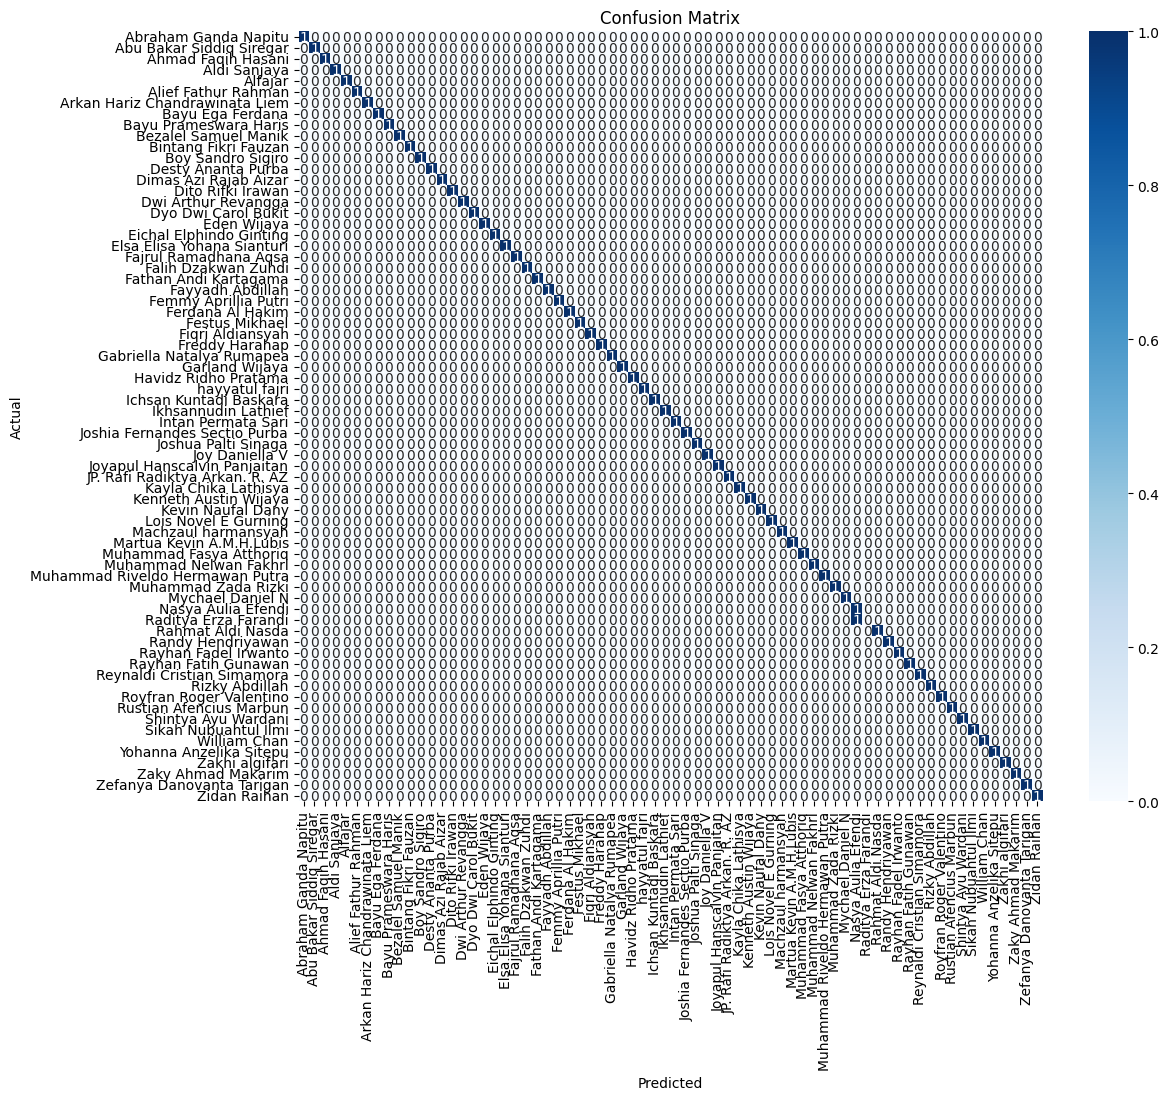

In [88]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

pred_prob = model_vgg.predict(X_test_vgg)
pred_labels = np.argmax(pred_prob, axis=1)

print("\nAccuracy:", accuracy_score(y_test, pred_labels))
print("\nClassification Report:")
print(classification_report(y_test, pred_labels, target_names=class_names))

cm = confusion_matrix(y_test, pred_labels)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [94]:
model_vgg.save("vgg_model.h5")
np.save("class_names.npy", np.array(class_names))
config = {
    "image_size": 224,
    "version": 2   # preprocess_input version
}

import json
with open("vgg_config.json", "w") as f:
    json.dump(config, f)


In [96]:
import numpy as np
import cv2
from mtcnn import MTCNN
from keras_vggface.utils import preprocess_input
from tensorflow.keras.models import load_model

# ================================
# 1. Load model & class names
# ================================

model_vgg = load_model("vgg_model.h5")
class_names = np.load("class_names.npy", allow_pickle=True)
detector = MTCNN()

IMAGE_SIZE = 224   # sama dengan training
PREPROCESS_VERSION = 2


# ================================
# 2. Face recognition inference
# ================================
def predict_image(image_path, threshold=0.5):

    # Load image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Face detection
    faces = detector.detect_faces(img_rgb)
    if len(faces) == 0:
        print("❌ No face detected")
        return None

    # Ambil bounding box wajah pertama
    x, y, w, h = faces[0]["box"]
    x, y = abs(x), abs(y)

    # Crop wajah
    face = img_rgb[y:y+h, x:x+w]

    # Resize
    face = cv2.resize(face, (IMAGE_SIZE, IMAGE_SIZE)).astype("float32")

    # Preprocess sesuai training
    face_pp = preprocess_input(face, version=PREPROCESS_VERSION)
    face_pp = np.expand_dims(face_pp, axis=0)

    # Predict
    preds = model_vgg.predict(face_pp)[0]
    idx = np.argmax(preds)
    conf = preds[idx]

    # Unknown handling
    if conf < threshold:
        print("❓ UNKNOWN FACE")
        print(f"Confidence: {conf:.4f}")
        return "Unknown"

    # Output
    print(f"🧑 Predicted: {class_names[idx]}")
    print(f"📊 Confidence: {conf:.4f}")

    return class_names[idx]


# ================================
# Contoh pemanggilan
# ================================
predict_image(
    r"C:/Alip/Machine Learning/Test/WhatsApp Image 2025-12-01 at 17.56.23_0afae0d3.jpg"
)


1/1 [==============================] - 1s 873ms/step
🧑 Predicted: Machzaul harmansyah
📊 Confidence: 0.9999


'Machzaul harmansyah'